In [2]:
%load_ext autoreload
%autoreload 2
from planetGenerator import PlanetGenerator
from planet import PlanetParameters
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from utils import Projection




from graph_tool.all import *

In [205]:
planetGenerator=PlanetGenerator(PlanetParameters(radius=6400,starTemperature=5778,starRadius=1,starDistance=0.85),36000,numberPlates=25,flood=0.7,seed=11)

In [206]:
planetGenerator.build()

Generate mesh seeds... Done in 12.4 ms
Relax mesh points... Done in 54.6 s
Create graph... Done in 14.2 s
Pick plates seeds... Done in 61.8 ms
Color plates... Done in 216.5 s
Pick plates type... Done in 10.7 ms
Compute resistance matrix within plates... Done in 136.5 s
Generate relief... Done in 60.2 s
Add random relief... Done in 2.5 s


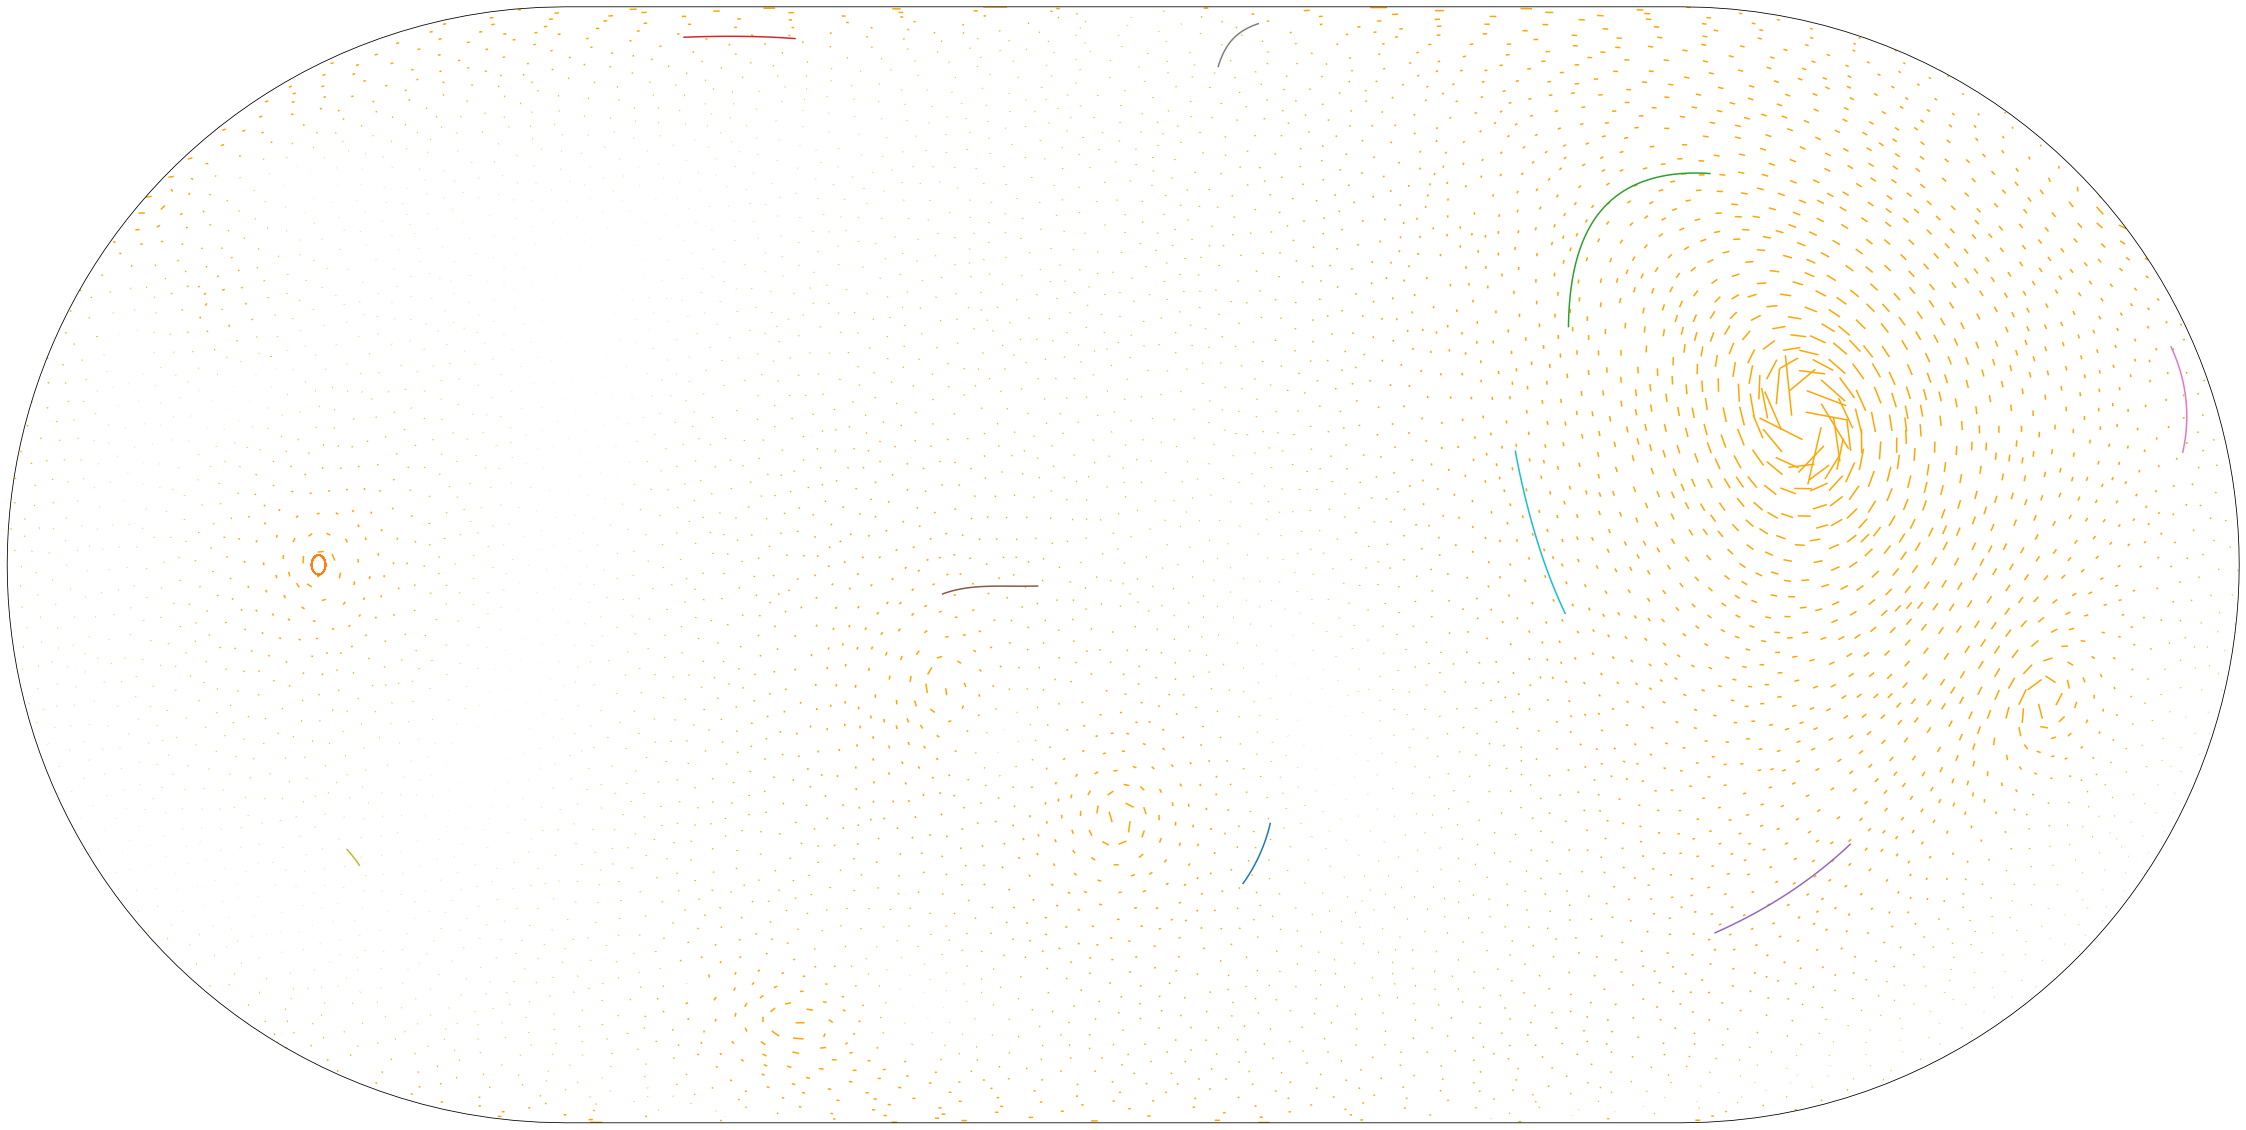

In [207]:
plt.figure(figsize=(40,30))
ax = plt.axes(projection=ccrs.EckertIV())
ax.set_global()


#planetGenerator.planet.plotTilesJunctions(ax,linestyle="dotted",color="r",zorder=np.inf)
#planetGenerator.planet.plotMeshPoints(ax,color="r",s=20,zorder=np.inf)
#planetGenerator.planet.plotRelief(ax,lw=0)
#planetGenerator.planet.plotTilesBorders(ax,color="k")
#planetGenerator.planet.plotPlatesBorders(ax,color="red",lw=2)
#planetGenerator.planet.plotPlatesSpeed(ax,color="orange",lw=1)
#planetGenerator.planet.plotPressure(ax,ec="white")
planet.plotWindSpeed(ax,color="orange")
for k in range(planet.lowerAtmosphere.numberOfSource):        
    lat,long=Projection().toLatLong(np.array(p[k]),"deg")
    ax.plot(long,lat,transform=ccrs.Geodetic())


plt.savefig("planet.pdf")
plt.show()

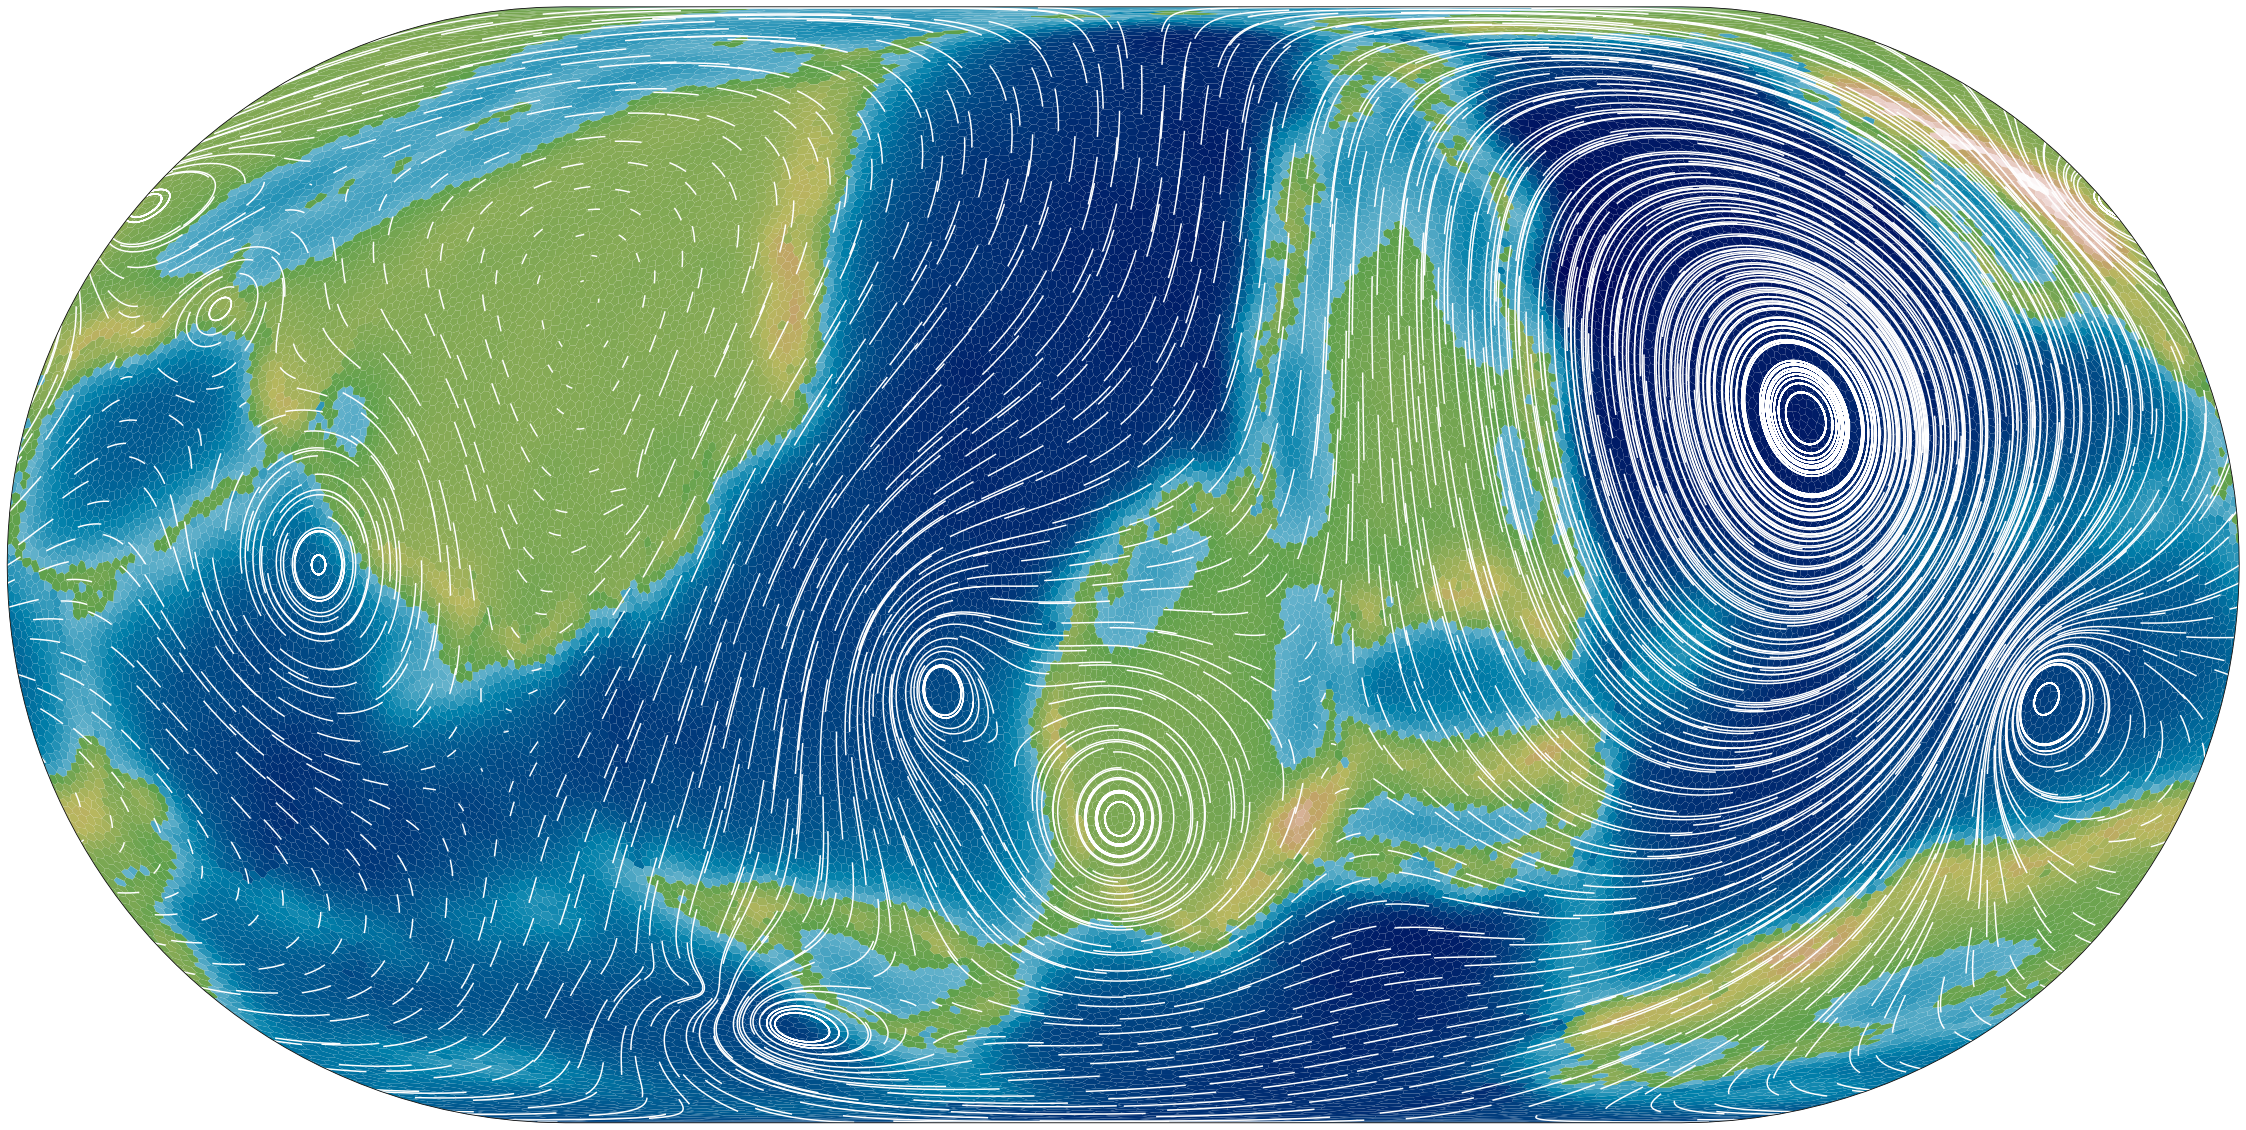

In [209]:
plt.figure(figsize=(40,30))
ax = plt.axes(projection=ccrs.EckertIV())
ax.set_global()


#planetGenerator.planet.plotTilesJunctions(ax,linestyle="dotted",color="r",zorder=np.inf)
#planetGenerator.planet.plotMeshPoints(ax,color="r",s=20,zorder=np.inf)
planetGenerator.planet.plotRelief(ax,lw=0)
#planetGenerator.planet.plotTilesBorders(ax,color="k")
#planetGenerator.planet.plotPlatesBorders(ax,color="red",lw=2)
#planetGenerator.planet.plotPlatesSpeed(ax,color="orange",lw=1)
#planetGenerator.planet.plotPressure(ax,ec="white")
#planet.plotWindSpeed(ax,color="orange")
for k in range(N):        
    lat,long=Projection().toLatLong(np.array(p[k]),"deg")
    ax.plot(long,lat,transform=ccrs.Geodetic(),color="white")


plt.savefig("planet.pdf")
plt.show()

In [193]:
class Atmosphere:
    def __init__(self,positions, sources, swirls,N):
        self.positions=np.array(positions)
        self.sources=np.array(sources)
        self.swirls=np.array(swirls)
        self.a=2/N
    def velocityField(self,positions):
        velocities=np.zeros_like(positions)
        for P_i,m_i,s_i in zip(self.positions,self.sources,self.swirls):
            P_i_long=np.tile(P_i,(len(positions),1))
            d=np.sum(P_i_long*positions,axis=-1)
            s=-m_i*(2*self.a)**.5*(P_i_long-d[:,None]*positions)/(1-d+self.a)[:,None]
            w=-s_i*(2*self.a)**.5*np.cross(P_i_long,positions)/(1-d+self.a)[:,None]
            velocities+=s+w          
        return velocities
    def update(self,duration,initialConditions=None):
        if initialConditions is None:
            initialConditions=self.positions
        def f(t,positions):
            return self.velocityField(np.reshape(positions,np.shape(initialConditions))).flatten()/planet.parameters.radius
        sol=solve_ivp(f,(0,duration),initialConditions.flatten(),atol=1e-3,rtol=1e-4)
        solution=np.reshape(sol.y[:,-1],np.shape(initialConditions))
        solution/=np.linalg.norm(solution,axis=-1)[:,None]
        return solution
    @property
    def numberOfSource(self):
        return len(self.positions)
    
N=10
windSeeds=np.random.normal(size=(N,3))
windSeeds/=np.linalg.norm(windSeeds,axis=-1)[:,None]
sources=np.random.normal(scale=5*0,size=N)
swirls=np.random.normal(scale=5,size=N)
planet=planetGenerator.planet
planet.lowerAtmosphere=Atmosphere(windSeeds,sources,swirls,planetGenerator.numberTiles)

import types
from matplotlib import collections as mc
from scipy.integrate import solve_ivp
def plotWindSpeed(self,ax,*args,**kwargs):
    dt=2/2./np.sqrt(self.meshCenters.num_vertices())
    p0=np.array(list(planet.meshCenters.vp.center))
    p1=p0+dt*self.lowerAtmosphere.velocityField(np.array(list(planet.meshCenters.vp.center)))
    lat0,long0=Projection().toLatLong(p0,"deg")
    lat1,long1=Projection().toLatLong(p1,"deg")
    lines=[[(long0[i],lat0[i]),(long1[i],lat1[i])] for i,_ in enumerate(lat0)]
    ax.add_collection(mc.LineCollection(lines,*args,transform=ccrs.Geodetic(),**kwargs))
planet.plotWindSpeed=types.MethodType(plotWindSpeed,planet)
p=[[] for i in range(planet.lowerAtmosphere.numberOfSource)]


In [168]:
#p=[[] for i in range(planet.lowerAtmosphere.numberOfSource)]
for i in range(400):
    planet.lowerAtmosphere.update(24)
    for k in range(planet.lowerAtmosphere.numberOfSource):
        p[k].append(planet.lowerAtmosphere.positions[k])



In [175]:
planet.lowerAtmosphere.update(24)

array([[ 0.96914969, -0.1317558 ,  0.20830095],
       [-0.65059449,  0.24674895,  0.71822125],
       [ 0.92484415,  0.33268023, -0.18435609],
       [-0.51594104, -0.31300221, -0.79739229],
       [ 0.39502113,  0.03613411, -0.91796113],
       [ 0.22154442,  0.45407328,  0.8629806 ],
       [-0.71268319,  0.55908955,  0.42367622],
       [ 0.45954719,  0.81180421, -0.36026421],
       [ 0.08936175,  0.16053719, -0.98297624],
       [ 0.7523995 ,  0.21000342,  0.62433449]])

In [203]:
N=1800
from mesh_generator import uniformPoints
windSeeds=uniformPoints(N,0)
p=[[] for i in range(N)]
for i in range(400):
    for k in range(N):
        p[k].append(windSeeds[k])
    windSeeds=planet.lowerAtmosphere.update(12,initialConditions=windSeeds)
    

(0.6488333333333334, 165.24728943818312)

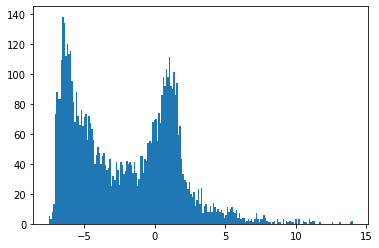

In [6]:
planet=planetGenerator.planet
plt.hist(planet.meshCenters.vp.elevation.a,bins=200);
elevation=planet.meshCenters.vp.elevation.a
len(elevation[elevation<0])/len(elevation),2*planet.parameters.radius/np.sqrt(planetGenerator.numberTiles)